A. Here are 400 random bits: 0000001101100100101000101100100110100000101001100100111101010000011111110100110101101000010111000100110111101101000110001101011011011000011010101100101111100011110010011110011011111010111000110110000100010111010110001111100011100111011101101111001110111110100101100010100100011110100010011110000111110011010101010000100001110101000101110110001001011011011111100111111110110101000000111111111110010100

1) Turn them into 200 random moves in the SmallGridWorld pictured below, in which there are two terminal states in gray and every move has reward -1: up=00, down=11, left=10, right=01.
2) Turn the 200 moves into episodes, each starting in state 5, the last episode possibly not terminating.
3) Starting with all state values equal to -18, apply first-visit Monte Carlo and Temporal Difference TD(0) with alpha = 0.1.
4) Visualize the updated state values after each episode.
5) Plot the root-mean squared error vs. episode number: $$RMS = \sqrt{\frac{1}{14} \sum_s \left( V(s) - v_\pi(s) \right)^2 }$$ where pi is the random policy.

![td.png](td.png)

In [8]:
# turning the action string into 200 action moves

action_string = "0000001101100100101000101100100110100000101001100100111101010000011111110100110101101000010111000100110111101101000110001101011011011000011010101100101111100011110010011110011011111010111000110110000100010111010110001111100011100111011101101111001110111110100101100010100100011110100010011110000111110011010101010000100001110101000101110110001001011011011111100111111110110101000000111111111110010100"

actions = [action_string[i:i+2] for i in range(0, len(action_string), 2)]
print(actions)

['00', '00', '00', '11', '01', '10', '01', '00', '10', '10', '00', '10', '11', '00', '10', '01', '10', '10', '00', '00', '10', '10', '01', '10', '01', '00', '11', '11', '01', '01', '00', '00', '01', '11', '11', '11', '01', '00', '11', '01', '01', '10', '10', '00', '01', '01', '11', '00', '01', '00', '11', '01', '11', '10', '11', '01', '00', '01', '10', '00', '11', '01', '01', '10', '11', '01', '10', '00', '01', '10', '10', '10', '11', '00', '10', '11', '11', '10', '00', '11', '11', '00', '10', '01', '11', '10', '01', '10', '11', '11', '10', '10', '11', '10', '00', '11', '01', '10', '00', '01', '00', '01', '01', '11', '01', '01', '10', '00', '11', '11', '10', '00', '11', '10', '01', '11', '01', '11', '01', '10', '11', '11', '00', '11', '10', '11', '11', '10', '10', '01', '01', '10', '00', '10', '10', '01', '00', '01', '11', '10', '10', '00', '10', '01', '11', '10', '00', '01', '11', '11', '00', '11', '01', '01', '01', '01', '00', '00', '10', '00', '01', '11', '01', '01', '00', '01', '01

In [9]:
import numpy as np
alpha = 0.1
reward = -1
# up=00, down=11, left=10, right=01
actions = ["00", "11", "10", "01"]


## First-Visit Monte Carlo

In [70]:
import numpy as np
num_states = 16
terminal_states = [0, 15]
mc_state_values = np.full(num_states, -18, dtype=float)
returns = [[] for _ in range(num_states)]
epsilon = 0.1
actions_map = {"00": "up", "11": "down", "10": "left", "01": "right"}

'''
Here i implemented first-visit monte carlo for the gridworld presented.
i set the parameters according to the homework and the environment
created next_state function to tell the computer what state we will end up in after an action
generated episode function to create episodes based on action sequences
lastly, the loop runs the first-visit monte carlo algorithm.
'''

def next_state(state, action):
  # 4x4 grid: states 0 (terminal), 1-14, 15 (terminal)
  if state in terminal_states:
    return state
  row, col = divmod(state, 4)
  if action == "00":  # up
    return state if row == 0 else (row - 1) * 4 + col

  if action == "11":  # down
    return state if row == 3 else (row + 1) * 4 + col

  if action == "10":  # left
    return state if col == 0 else state - 1

  if action == "01":  # right
    return state if col == 3 else state + 1

  return state

def generate_random_episode(actions, start_state=5):
    episode = []
    state = start_state
    for action in actions:
      episode.append((state, action, -1))
      state = next_state(state, action)
      if state in terminal_states:
        break
    return episode

# run many episodes and only update the state value if it hasnt been visited yet
for _ in range(160):  # number of episodes
    # take random actions
    episode_actions = np.random.choice(list(actions_map.keys()), 160)
    episode = generate_random_episode(episode_actions)
    visited = set()
    G = 0
    for t in reversed(range(len(episode))):
      state, action, reward = episode[t]
      G += reward
      if state not in visited:
        returns[state].append(G)
        mc_state_values[state] = np.mean(returns[state])
        visited.add(state)
        

# print visited states so we can check that the first-visit mc was implemented correctly
visited_states = [i for i, r in enumerate(returns) if len(r) > 0]
print("Visited states:", visited_states)
# check if mc state values are reasonable
print(mc_state_values)


Visited states: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[-18.          -6.97619048 -10.81666667 -12.97368421  -6.0212766
  -8.525       -8.74193548  -9.83636364  -9.66197183  -9.15957447
  -8.60465116  -6.77083333 -12.14285714 -10.67213115  -9.33928571
 -18.        ]


## Temporal Difference TD(0)

V(s) ← V(s) +α[r+γV(s′)−V(s)]

In [71]:
num_episodes = 160 # closer to the episodes used in MC (10 episodes (200 actions / chunk size of 20) per start state (16 in total))
alpha = 0.1
gamma = 1.0 # undiscounted
td_state_values = np.full(num_states, -18, dtype=float)
starting_state = 5

# td(0) with random actions is implemented
def td_zero(num_episodes, alpha, gamma):
    for _ in range(num_episodes):
        state = starting_state
        while state not in terminal_states:
            action = np.random.choice(list(actions_map.keys())) # choose random action
            # get next state based on random action
            next_s = next_state(state, action)
            reward = -1

            # TD(0) update (use td_state_values for both current and next state)
            td_state_values[state] += alpha * (
                reward + gamma * td_state_values[next_s] - td_state_values[state]
            )

            state = next_s

td_zero(num_episodes, alpha, gamma)
print(td_state_values)

[-18.         -27.61968088 -31.55943967 -32.20835305 -28.47168481
 -30.24231229 -31.95939562 -31.7631286  -32.59902401 -32.07031586
 -31.14923709 -29.04202697 -33.52553261 -31.18916309 -27.82098245
 -18.        ]


In [29]:
import matplotlib.pyplot as plt

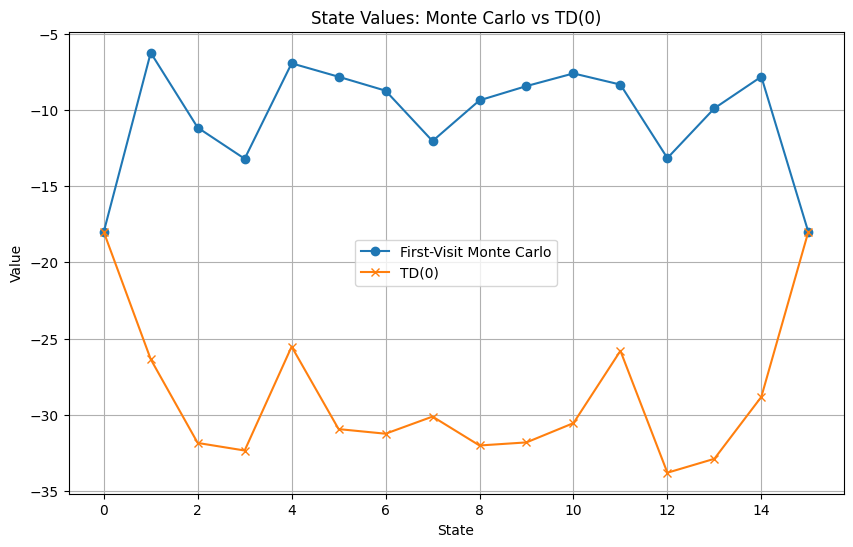

In [68]:
# Plot MC and TD(0) state values on the same graph
plt.figure(figsize=(10, 6))
plt.plot(mc_state_values, marker='o', label='First-Visit Monte Carlo')
plt.plot(td_state_values, marker='x', label='TD(0)')
plt.xlabel('State')
plt.ylabel('Value')
plt.title('State Values: Monte Carlo vs TD(0)')
plt.legend()
plt.grid(True)
plt.show()

Root Mean Squared Error RMS: missing